## Description

This file will contain the analysis of brain recordings comparing resting state behavior with tapping activity. 
It will take the following steps:

1. Prepare environment
2. Import data (1 participant at a time)
3. Clean data:
    1. Apply filtering (0.5 - 50Hz)
    2. Apply Notch
    3. Remove flatlined channels
    4. Mark noisy channels
    5. Perform ICA
    6. Remove components that correlated with EOG and ECG
    7. Remove muscle components (spiky activity in 20-50Hz frequency range)
    8. Interpolate noisy channels
4. Re-reference data
5. Analyse data...

In [1]:
# Install required libraries

%pip install mne numpy matplotlib PyQt5 scikit-learn



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Perform required imports

import PyQt5
import mne
import matplotlib.pyplot as plt
import numpy as np
from mne.preprocessing import ICA
import sklearn
from mne.time_frequency import psd_array_welch
%matplotlib qt


In [2]:
# Load the EEG data (.vhdr header file format)
eeg_file = '../Data/Pilot/P03/Apathy_Agency_2025-02-12_14-49-52.vhdr'  
raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Extracting parameters from ../Data/Pilot/P03/Apathy_Agency_2025-02-12_14-49-52.vhdr...
Setting channel info structure...
Reading 0 ... 8430311  =      0.000 ...  8430.311 secs...


C:\Users\ymijs\AppData\Local\Temp\ipykernel_28708\544543895.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


In [3]:
# Filter data to be within the 0.5 and 50 Hz frequency bands, outside is likely noise
raw.filter(l_freq=0.5, h_freq=40.0)  


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   48.9s


<RawBrainVision | Apathy_Agency_2025-02-12_14-49-52.eeg, 68 x 8430312 (8430.3 s), ~4.27 GB, data loaded>

In [4]:
# Set ECG, EOG and Photodiode channels
raw.set_channel_types({
    'BIP3': 'dipole',  # Replace 'ECG' with the actual name of your ECG channel
    'BIP7': 'ecg',  # Replace 'EOG1' with the actual name of your EOG channel
    'BIP8': 'eog',    # Replace 'EMG' with the actual name of your EMG channel
    'BIP9': 'eog'    # Replace 'EMG' with the actual name of your EMG channel
})


C:\Users\ymijs\AppData\Local\Temp\ipykernel_28708\2067019438.py:2: RuntimeWarning: The unit for channel(s) BIP3 has changed from V to NA.
  raw.set_channel_types({


<RawBrainVision | Apathy_Agency_2025-02-12_14-49-52.eeg, 68 x 8430312 (8430.3 s), ~4.27 GB, data loaded>

In [5]:
# Remove EOG channel, which was connected to cap, but was not used, same for M1 and M2
unused_channels = ['M1', 'M2'] # Build-in EOG channel in cap was not used
raw.drop_channels(unused_channels)


<RawBrainVision | Apathy_Agency_2025-02-12_14-49-52.eeg, 66 x 8430312 (8430.3 s), ~4.15 GB, data loaded>

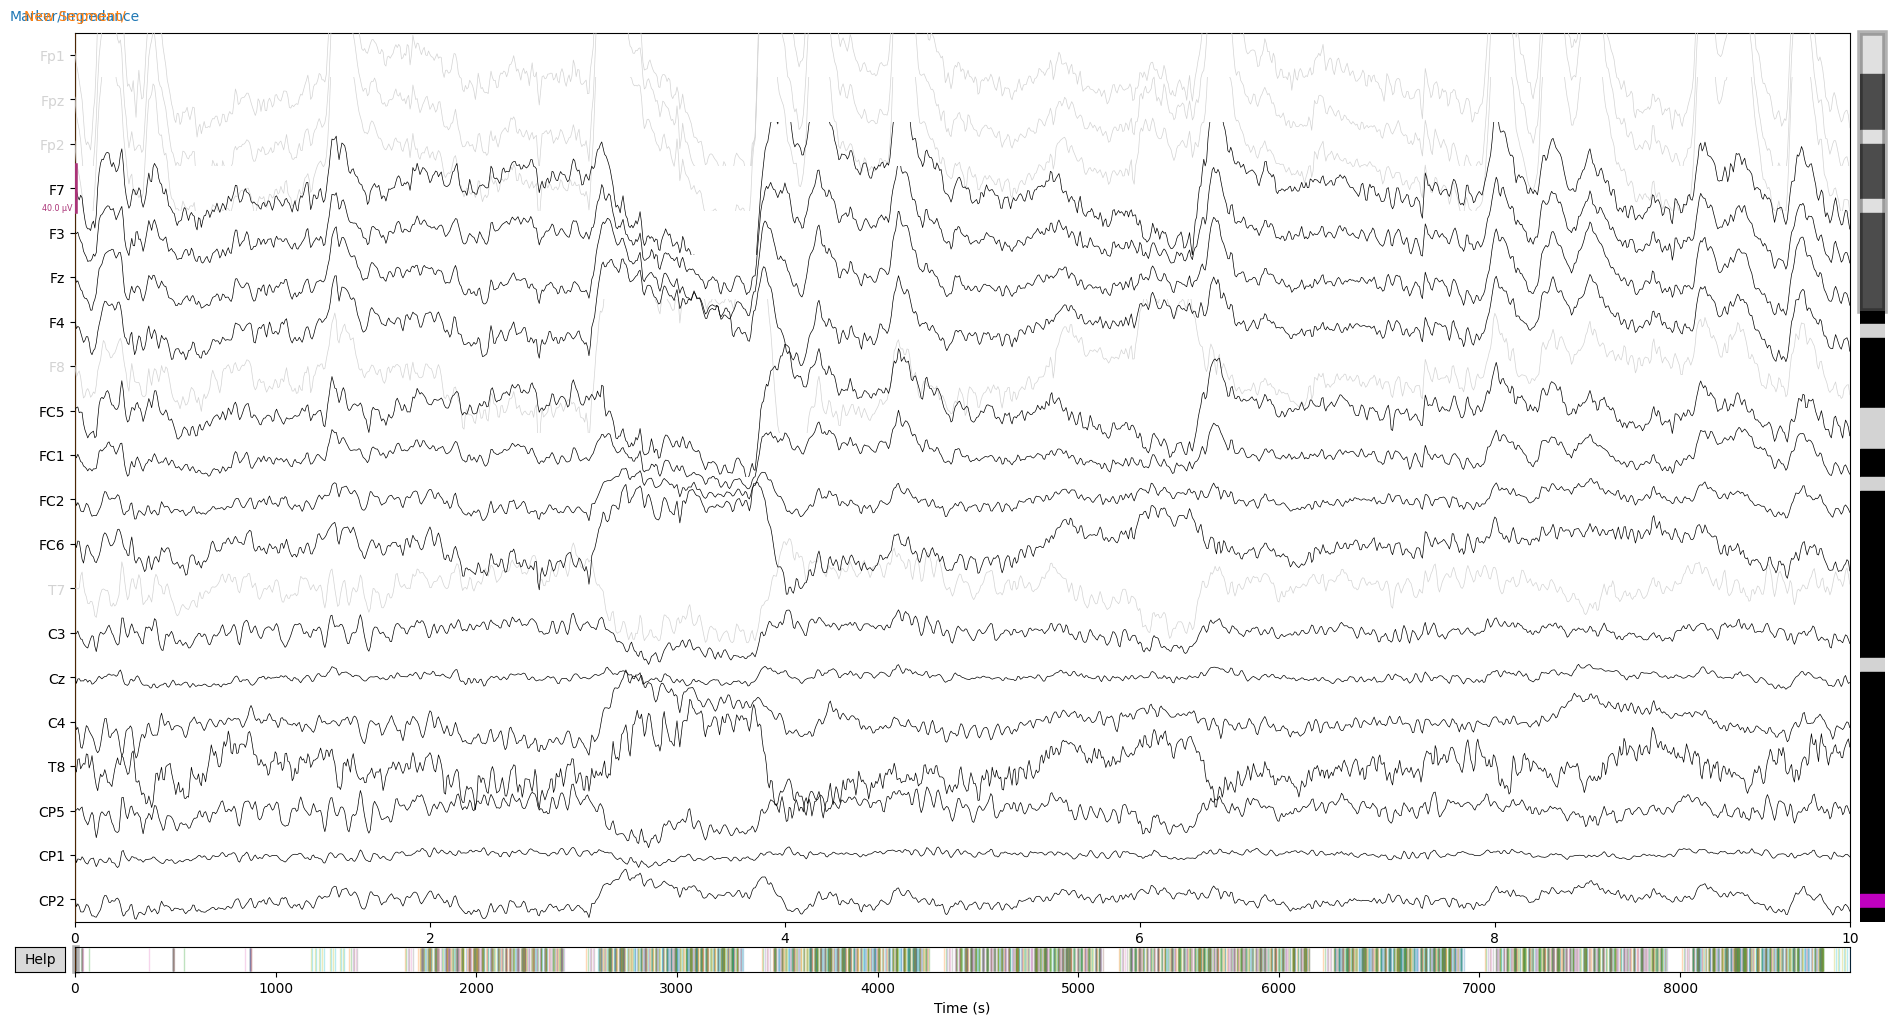

Channels marked as bad:
['Fp1', 'Fpz', 'Fp2', 'F8', 'T7', 'P7', 'O1', 'Oz', 'AF7', 'AF8', 'CP4']
Channels marked as bad:
none


In [22]:
raw.plot(duration=10, title='Raw Recoding filtered')


In [8]:
# Completely remove flatlined channels, before ICA 
raw.info['bads'] = []
non_eeg_channels = ['BIP3', 'BIP7', 'BIP8', 'BIP9']

# Identify flat-lined channels and mark them as bad
channel_std = np.std(raw.get_data(), axis=1)
flatlined_channels = [ch_name for ch_name, std in zip(raw.ch_names, channel_std) if std < 1e-6]
print(f"Flatlined channels: {flatlined_channels}")
raw.drop_channels(flatlined_channels)

# Identify noisy channels, mark them as bad, but don't drop them just yet
# Calculate peak-to-peak amplitude for each channel
channel_ranges = np.ptp(raw.get_data(), axis=1)

# Define a threshold for noisy channels (e.g., > 150 μV)
noisy_channels = [ch_name for ch_name, rng in zip(raw.ch_names, channel_ranges) if rng > 350e-6]
print(f"Noisy channels: {noisy_channels}")
raw.info['bads'].extend(noisy_channels)
raw.info['bads'] = [
    ch_name for ch_name in raw.info['bads']
    if ch_name not in non_eeg_channels
]# Mark them as bad
print(len(raw.info['bads']))
print(raw.info['bads'])



Flatlined channels: ['O2']
Noisy channels: ['Fp1', 'Fpz', 'Fp2', 'F8', 'T7', 'P7', 'O1', 'Oz', 'AF7', 'AF8', 'CP4', 'Oz_1', 'BIP3', 'BIP7', 'BIP8', 'BIP9']
12
['Fp1', 'Fpz', 'Fp2', 'F8', 'T7', 'P7', 'O1', 'Oz', 'AF7', 'AF8', 'CP4', 'Oz_1']


In [11]:
raw_filtered.plot(duration=10, title='Raw Recoding filtered')


NameError: name 'raw_filtered' is not defined

In [9]:
# Apply ICA, with flatlined channels dropped (not interpolated) and with noisy channels just marked as bad
# Note that we interpolate after ICA

# Apply montage to indicate setup of the EEG cap, following the standard 10-20 setup
raw.drop_channels('Oz_1')
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Start ICA on a recording copy that filter 1Hz
ica_raw = raw.copy()
ica_raw.filter(l_freq=1, h_freq=40.0)  

# Create the ICA Component, starting with 25 components (can be 15-25)
ica = ICA(n_components=25, random_state=42, max_iter=800)

# Fit the ICA model to the raw EEG data
ica.fit(ica_raw)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.5s


Fitting ICA to data using 49 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 531.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,47 iterations on raw data (8846606 samples)
ICA components,25
Available PCA components,49
Channel types,eeg
ICA components marked for exclusion,—


In [16]:
# Analyse ICA components that were found
ica.plot_components()  # Component index 10
# ica.plot_properties(ica_raw)


[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x260 with 5 Axes>]

In [11]:
# Start removing EOG Components from the ICA, comparing to the EOG Channel

eog_indices, _ = ica.find_bads_eog(ica_raw)
print(f"Bad components identified: {eog_indices}")
ica.exclude = eog_indices


Using EOG channels: BIP8, BIP9
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.8s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   13.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Bad components identified: [np.int64(3), np.int64(0)]


In [12]:
# Remove ECG related components

ecg_indices, _ = ica.find_bads_ecg(ica_raw)
print(f"Bad ECG-related components: {ecg_indices}")
ica.exclude += ecg_indices


Using threshold: 0.16 for CTPS ECG detection


Using channel BIP7 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 11658 (average pulse 79.06761078768513 / min.)
Not setting metadata
11658 matching events found
No baseline correction applied
Using data from preloaded Raw for 11658 events and 1001 original time points ...
1 bad epochs dropped
Bad ECG-related components: [np.int64(4)]


In [15]:
# Visualize Power Spectrum of each component to identify muscle artifacts
# For muscle artifacts, find components that show spiky data in the high frequency band

# Calculate the power spectrum for each ICA component
n_components = ica.n_components_
for i in range(n_components):
    # Get the ICA component signals
    component_data = ica.get_sources(ica_raw).get_data(picks=[i])[0]
    # Compute the power spectrum
    psd, freqs = psd_array_welch(component_data, sfreq=raw.info['sfreq'], fmin=1, fmax=50, n_fft=2048)

    # Plot the power spectrum
    plt.figure(figsize=(6, 4))
    plt.plot(freqs, psd)
    plt.title(f'Power Spectrum of ICA Component {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.show()

    # Identify components with high frequency (>20 Hz) peaks for muscle activity


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\1137042156.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


In [15]:
# Set a threshold for detecting muscle artifacts based on power in the 20-50 Hz range
MUSCLE_THRESHOLD = 0.1  # This is an example threshold, adjust based on your data

# Visualize and check power spectrum for each ICA component
n_components = ica.n_components_  # Get the number of ICA components

# List to store the indices of components identified as muscle artifacts
muscle_artifact_components = []

for i in range(n_components):
    # Get the ICA component time series (channels x samples)
    component_data = ica.get_sources(ica_raw).get_data(picks=[i])[0]  
    
    # Compute the power spectrum for the component (frequency range 1 to 50 Hz)
    psd, freqs = psd_array_welch(component_data, sfreq=raw.info['sfreq'],
                                  fmin=1, fmax=50, n_fft=2048, output='power')
    
    # Define the frequency range above 20 Hz
    high_freq_range = (freqs >= 20)  # Frequencies greater than or equal to 20 Hz
    
    # Get the power values in the high-frequency range (20-50 Hz)
    high_freq_psd = psd[high_freq_range]
    
    # Find the maximum power in the high-frequency range (muscle artifact region)
    peak_power = np.max(high_freq_psd)  # Maximum value in the high-frequency range
    
    # Check if the peak power exceeds the threshold
    if peak_power > MUSCLE_THRESHOLD:
        print(f"Component {i} likely contains muscle artifacts (peak power: {peak_power:.3f})")
        muscle_artifact_components.append(i)  # Mark the component as a muscle artifact

# Now you have a list of components likely to contain muscle artifacts
print(f"\nTotal number of muscle artifact components detected: {len(muscle_artifact_components)}")

# ica.exclude += muscle_artifact_components  # Add the indices of the muscle artifact components to ica.exclude



Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)

Total number of muscle artifact components detected: 0


In [17]:
# Apply ICA exclusions to the data (so after identifying EOG, ECG and Muscle Artifacts)
# We will call this new dataset resting_state_clean

clean = raw.copy()
ica.apply(clean)



Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 10 ICA components
    Projecting back using 49 PCA components


<RawBrainVision | Apathy_Agency_2025-02-11_10-26-45.eeg, 64 x 8846606 (8846.6 s), ~4.22 GB, data loaded>

In [18]:
# Interpolate bad channels

# If there are bad channels, interpolate them
clean.interpolate_bads()  # This will interpolate the marked bad channels

# Verify the interpolation was done
clean.info['bads']  # Check if there are still bad channels


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 49 sensor positions
Interpolating 11 sensors


[]

In [19]:
# Now we rereference the data to the average of the EEG electrodes

# Apply the average reference to the cleaned resting state data
clean.set_eeg_reference('average', projection=False)
# Check the new reference information
print(clean.info)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 60 EEG, 1 Dipole, 1 ECG, 2 EOG
 custom_ref_applied: True
 dig: 63 items (3 Cardinal, 60 EEG)
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-02-11 10:26:45 UTC
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>


In [23]:
# Plot Resting State Cleaned
print(clean.get_data().shape)

clean.plot(duration=10, title='Cleaned Recording')




(64, 8846606)
Overwriting existing file.
Writing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\p01_cleaned_EEG.fif


C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\4180588226.py:6: RuntimeWarning: This filename (c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\p01_cleaned_EEG.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  clean.save("p01_cleaned_EEG.fif", overwrite=True)


Closing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\p01_cleaned_EEG.fif
Overwriting existing file.
Writing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\p01_cleaned_EEG-1.fif
Closing c:\Users\ymijs\OneDrive\Documents\Internship\Apathy-Agency\EEG Experiment\Data Analysis\p01_cleaned_EEG-1.fif
[done]


Channels marked as bad:
none


In [ ]:
clean.save("p01_cleaned_EEG.fif", overwrite=True)


### Analysis

Now we continue with running the analysis. First getting the resting state data and dividing it in Epochs.

#### First we extract the Resting State Data and divide it into Epochs

In [26]:
# Crop the data to the resting state time window

# Start with a more "general" cut to get a braoder area, this is to prevent finding other events with the same code
resting_state_area = clean.copy().crop(tmin=70, tmax=380)

# Transform the annotations in the data (coming from the triggers) to actual events
resting_state_events, resting_state_event_id = mne.events_from_annotations(resting_state_area)

# Inspect the events
print(resting_state_events)

# Extract the resting state segment
start_sample = resting_state_events[0, 0]    # End sample from 's0'
print(start_sample)
end_sample = resting_state_events[1, 0]    # End sample from 's255'
print(end_sample)
# Create a new dataset with only the resting state data
resting_state = clean.copy().crop(tmin=start_sample / raw.info['sfreq'], tmax=end_sample / raw.info['sfreq'])
print(resting_state.get_data().shape)


Used Annotations descriptions: [np.str_('Stimulus/s1'), np.str_('Stimulus/s255')]
[[ 71382      0  10001]
 [371391      0  10002]]
71382
371391
(64, 300010)


In [98]:
# Crop the data to the resting state time window

# Start with a more "general" cut to get a braoder area, this is to prevent finding other events with the same code
resting_state_area_2 = clean.copy().crop(tmin=544, tmax=850)

# Transform the annotations in the data (coming from the triggers) to actual events
resting_state_events_2, resting_state_event_id_2 = mne.events_from_annotations(resting_state_area_2)

# Inspect the events
print(resting_state_events_2)

# Extract the resting state segment
start_sample_2 = resting_state_events_2[0, 0]  # Start sample from 's1'
end_sample_2 = resting_state_events_2[1, 0]    # End sample from 's255'

# Create a new dataset with only the resting state data
resting_state_2 = clean.copy().crop(tmin=start_sample_2 / raw.info['sfreq'], 
                                    tmax=end_sample_2 / raw.info['sfreq'])


Used Annotations descriptions: [np.str_('Stimulus/s1'), np.str_('Stimulus/s255')]
[[545402      0  10001]
 [845412      0  10002]]


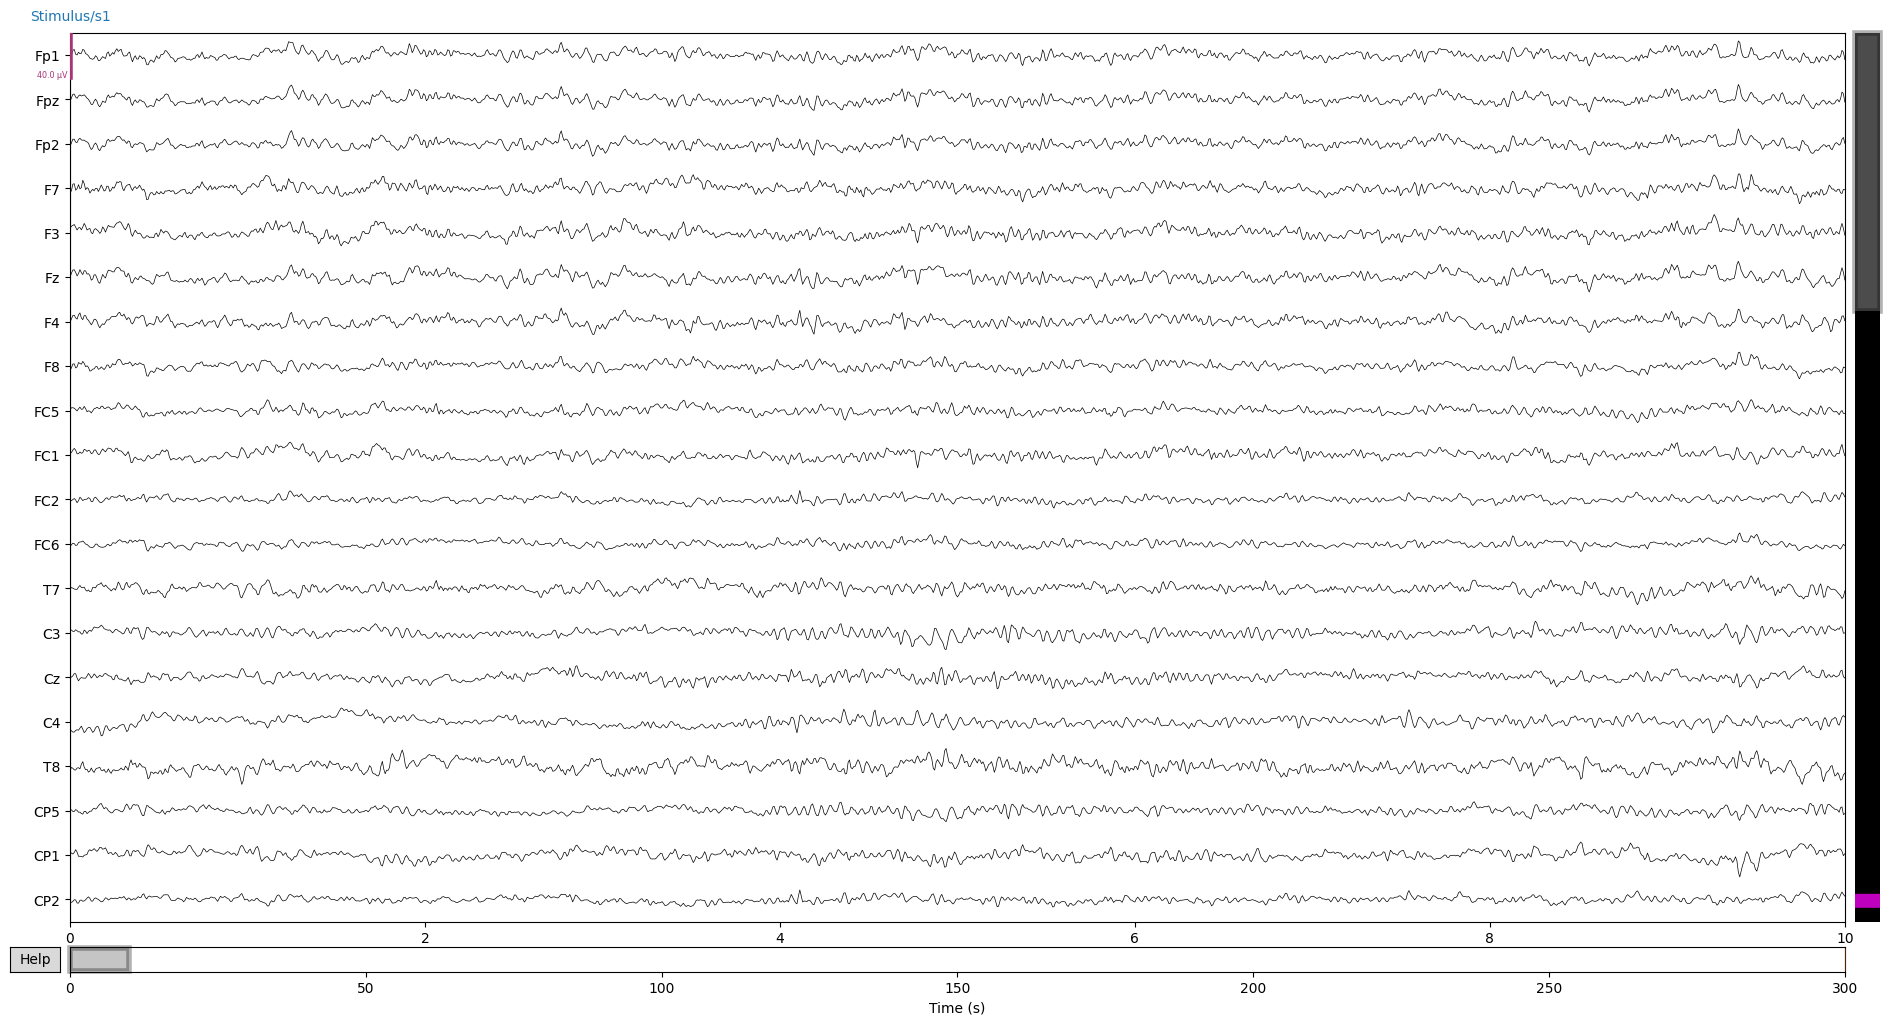

Channels marked as bad:
none


In [30]:
resting_state.plot()


In [99]:
# Divide the resting state data into 10s epochs

# Create epochs from the resting state segment
tmin = 0  # Start of each epoch
tmax = 10  # Duration of each epoch in seconds
resting_epochs = mne.make_fixed_length_epochs(resting_state, duration=tmax, preload=True)
resting_epochs_2 = mne.make_fixed_length_epochs(resting_state_2, duration=tmax, preload=True)

# Visualize the epochs
#resting_epochs.plot()
print(resting_epochs.get_data().shape)
print(resting_epochs_2.get_data().shape)

resting_epochs.save("p01_resting-1-epo.fif", overwrite=True)
resting_epochs_2.save("p01_resting-2-epo.fif", overwrite=True)



Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 10000 original time points ...
0 bad epochs dropped
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 10000 original time points ...
0 bad epochs dropped
(30, 64, 10000)
(30, 64, 10000)


#### Then we extract the tapping data and divide it into epochs

In [31]:
# Crop the data to the resting state time window

# Start with a more "general" cut to get a braoder area, this is to prevent finding other events with the same code
tapping_area = clean.copy().crop(tmin=1626, tmax=8735)

# Extract the key events
tapping_events, tapping_events_id = mne.events_from_annotations(tapping_area)


Used Annotations descriptions: [np.str_('Stimulus/s1'), np.str_('Stimulus/s10'), np.str_('Stimulus/s106'), np.str_('Stimulus/s107'), np.str_('Stimulus/s108'), np.str_('Stimulus/s109'), np.str_('Stimulus/s11'), np.str_('Stimulus/s110'), np.str_('Stimulus/s111'), np.str_('Stimulus/s114'), np.str_('Stimulus/s115'), np.str_('Stimulus/s116'), np.str_('Stimulus/s117'), np.str_('Stimulus/s118'), np.str_('Stimulus/s119'), np.str_('Stimulus/s12'), np.str_('Stimulus/s122'), np.str_('Stimulus/s123'), np.str_('Stimulus/s124'), np.str_('Stimulus/s125'), np.str_('Stimulus/s126'), np.str_('Stimulus/s127'), np.str_('Stimulus/s13'), np.str_('Stimulus/s130'), np.str_('Stimulus/s131'), np.str_('Stimulus/s132'), np.str_('Stimulus/s133'), np.str_('Stimulus/s134'), np.str_('Stimulus/s135'), np.str_('Stimulus/s14'), np.str_('Stimulus/s15'), np.str_('Stimulus/s162'), np.str_('Stimulus/s163'), np.str_('Stimulus/s164'), np.str_('Stimulus/s165'), np.str_('Stimulus/s166'), np.str_('Stimulus/s167'), np.str_('Stimu

In [81]:
# What follows here is a slightly more complex analysis of the different stimuli codes to identify the start and end of specific tapping events 

# First map each event ID to its relevant binary code (in int)
event_id_to_binary = {
    code: int(desc.split('/s')[-1]) for desc, code in tapping_events_id.items() if 'Stimulus/s' in desc
}

# Identify start and end of tapping events, marked by a 64 bit exclusion and a 1 bit on or off for start or end
def is_tapping_start(binary_val):
    return (binary_val & 128 == 0) and (binary_val & 64 == 0) and (binary_val & 1 == 0)

def is_tapping_end(binary_val):
    return (binary_val & 128 == 0) and (binary_val & 64 == 0) and (binary_val & 1 == 1)

def match_previous_event_as_start(end_events, all_events):
    matched_events = []

    # Iterate through the end events
    for i, end in enumerate(end_events):
        # Ensure we are not at the start of the list (i.e., there is a previous event)
        if i > 0:
            # The start event is the event right before the current end event
            start = all_events[all_events.tolist().index(end.tolist()) - 1]
            matched_events.append((start, end))

    return matched_events


# Store starting and ending events
tapping_end_events = []
tapping_start_events = []

for event in tapping_events:  # Iterate over all events
    event_code = event[2]
    if event_code in event_id_to_binary:  # Only process stimulus events
        binary_val = event_id_to_binary[event_code]
        if is_tapping_end(binary_val):
            tapping_end_events.append(event)

for event in tapping_events:  # Iterate over all events
    event_code = event[2]
    if event_code in event_id_to_binary:  # Only process stimulus events
        binary_val = event_id_to_binary[event_code]
        if is_tapping_start(binary_val):
            tapping_start_events.append(event)

print(len(tapping_end_events))
print(len(tapping_start_events))

all_tapping_pairs = match_previous_event_as_start(tapping_end_events, tapping_events)

print(len(all_tapping_pairs))

# Function to filter out the start events that do not exist in tapping_start_events
def get_non_matching_start_events(all_tapping_pairs, tapping_start_events):
    non_matching_start_events = []

    # Extract the event codes from tapping_start_events for comparison
    start_event_codes = {event[2] for event in tapping_start_events}  # Assuming event[2] is the event code
    
    # Iterate over all the tapping pairs
    for start, end in all_tapping_pairs:
        # Compare only the event code (start[2]) instead of the entire event
        if start[2] not in start_event_codes:
            non_matching_start_events.append((start, end))

    return non_matching_start_events

# Get all the pairs of events (start, end) as previously done
all_tapping_pairs = match_previous_event_as_start(tapping_end_events, tapping_events)

# Get the non-matching start events
non_matching_start_events = get_non_matching_start_events(all_tapping_pairs, tapping_start_events)



# As there is a mismatch between starting and ending events we will look for end events that happen within 7.5 seconds after the start of the tapping event and pair the first end event in that timeframe with the starting event
def match_start_end_events(all_tapping_pairs, time_window=8):
    matched_events = []

    for start, end in all_tapping_pairs:
        start_time = start[0] / tapping_area.info['sfreq']  # Convert sample index to time in seconds
        # Search for the end event within 8 seconds after the start event
        end_time = end[0] / raw.info['sfreq']  # Convert sample index to time in seconds
        if start_time < end_time <= (start_time + time_window):
            matched_events.append((start, end))
            break  # Once we find the first matching end, we move to the next start event

    return matched_events

#all_tapping_pairs_matched = match_start_end_events(all_tapping_pairs, time_window=8)

#print(len(all_tapping_pairs_matched))

# Calculate the duration of each tapping pair (end time - start time)
tapping_durations = np.array([end[0] - start[0] for start, end in all_tapping_pairs])
# Filter out tapping pairs with a duration less than 7 seconds (assuming the sampling rate is known, e.g., 1000 Hz)
# If the sampling rate is 1000 Hz, 7 seconds would correspond to 7000 samples. 
# Adding a 200ms boundary because the timing of the triggers is not perfect and the there might be a ms-level difference between start and end that make it less than 7 seconds
min_duration_samples = 7 * 1000 - 200 # adjust this based on your actual sampling rate
valid_tapping_indices = tapping_durations >= min_duration_samples
# Now we filter the tapping pairs to include only the valid ones
valid_tapping_pairs = np.array(all_tapping_pairs)[valid_tapping_indices]

print(len(valid_tapping_pairs))


1082
679
1081
284


In [116]:
# Now divide the tapping events into 10s filters starting at event -1s and ending at event +2 seconds
valid_tapping_pairs_start = np.array([start for start, end in valid_tapping_pairs])

print(len(valid_tapping_pairs_start))
# Starting time of epoch is 1 second before tapping
tmin= -5

# End time of epoch is 2 seconds after end (or 9 seconds after start)
tmax= 9

tapping_epochs_readiness = mne.Epochs(
    tapping_area,  # The raw EEG data object
    valid_tapping_pairs_start,  # Your events (need to be in the format [index, id, time])
    event_id=None,  # You can use a specific event id if needed, or just pass None
    tmin=tmin,  # Start time relative to event (in seconds)
    tmax=tmax,  # End time relative to event (in seconds)
    baseline=None,  # No baseline correction for now
    picks='all',  # Pick all channels
)

tapping_epochs_readiness.save("p01_tapping-epo-readiness-pot.fif", overwrite=True)


284
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 284 events and 14001 original time points ...


C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\1661728484.py:21: RuntimeWarning: This filename (p01_tapping-epo-readiness-pot.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  tapping_epochs_readiness.save("p01_tapping-epo-readiness-pot.fif", overwrite=True)


0 bad epochs dropped
Using data from preloaded Raw for 1 events and 14001 original time points ...
Using data from preloaded Raw for 284 events and 14001 original time points ...


Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\1617034679.py:20: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked_avg.plot( spatial_colors=True)


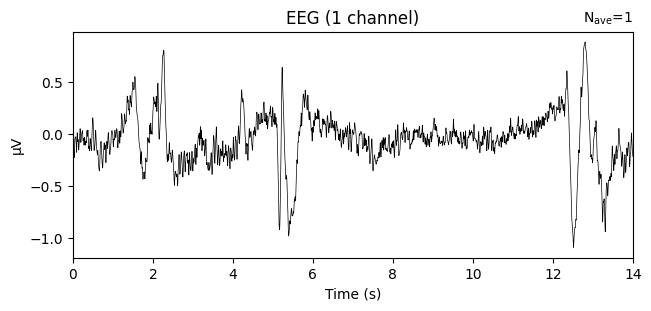

In [96]:
# Pick the channels of interest (adjust to your channel names)
channels_of_interest = ['C3', 'Cz', 'C4', 'F3', 'F4', 'T7', 'T8']

# Select the channels and get the data
data = tapping_epochs_readiness.copy().pick(channels_of_interest).get_data()

# Average across the selected channels (axis=1) and then across epochs (axis=0)
tapping_epochs_avg = data.mean(axis=1).mean(axis=0)

# Reshape to match the expected input for EvokedArray (1 channel, n_times)
tapping_epochs_avg = tapping_epochs_avg[np.newaxis, :]

# Create a new info object for the averaged channel (only 1 channel here)
info = mne.create_info(ch_names=['Avg_C3_Cz_C4'], sfreq=tapping_area.info['sfreq'], ch_types='eeg')

# Create the Evoked object to visualize the averaged data
evoked_avg = mne.EvokedArray(tapping_epochs_avg, info)

# Plot the averaged readiness potential
evoked_avg.plot( spatial_colors=True)


Using data from preloaded Raw for 284 events and 14001 original time points ...
Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1321 samples (1.321 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    5.7s
[Parallel(n_job

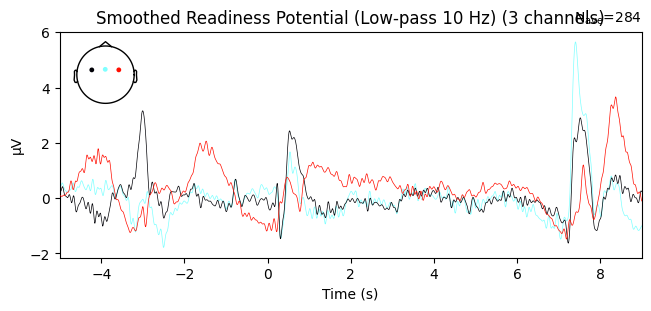

In [89]:
tapping_epochs_readiness.load_data()

# Apply a low-pass filter at 10 Hz (or lower for smoother curves)
tapping_epochs_smooth = tapping_epochs.copy().filter(l_freq=None, h_freq=10)

# Average the smoothed data
evoked_smooth = tapping_epochs_smooth.average(picks=['Cz', 'C3', 'C4'])

# Plot the smoothed average
evoked_smooth.plot(spatial_colors=True, titles="Smoothed Readiness Potential (Low-pass 10 Hz)")


In [117]:
# Remove BIP channels because we don't care about them anymore for analysis
# Now divide the tapping events into 10s filters starting at event -1s and ending at event +2 seconds
valid_tapping_pairs_start = np.array([start for start, end in valid_tapping_pairs])

print(len(valid_tapping_pairs_start))
# Starting time of epoch is 1 second before tapping
tmin= 0

# End time of epoch is 2 seconds after end (or 9 seconds after start)
tmax= 7

tapping_epochs = mne.Epochs(
    tapping_area,  # The raw EEG data object
    valid_tapping_pairs_start,  # Your events (need to be in the format [index, id, time])
    event_id=None,  # You can use a specific event id if needed, or just pass None
    tmin=tmin,  # Start time relative to event (in seconds)
    tmax=tmax,  # End time relative to event (in seconds)
    baseline=None,  # No baseline correction for now
    picks='all',  # Pick all channels
)

tapping_epochs_readiness.save("p01_tapping-epo-tapping.fif", overwrite=True)

# Channels to remove
channels_to_remove = ['BIP3', 'BIP7', 'BIP8', 'BIP9']

# Pick only the remaining channels
remaining_channels_rest = [ch for ch in resting_epochs_2.info['ch_names'] if ch not in channels_to_remove]
remaining_channels_tap = [ch for ch in tapping_epochs.info['ch_names'] if ch not in channels_to_remove]

print(remaining_channels_rest)
tapping_epochs.load_data()
resting_epochs_2 = resting_epochs_2.pick(remaining_channels_rest)# Compute the PSD for each epoch and channel for both conditions
tapping_epochs = tapping_epochs.pick(remaining_channels_tap)# Compute the PSD for each epoch and channel for both conditions

print(resting_epochs_2.get_data().shape)
print(tapping_epochs.get_data().shape)



284
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 14001 original time points ...
Using data from preloaded Raw for 284 events and 14001 original time points ...


C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\1441815944.py:22: RuntimeWarning: This filename (p01_tapping-epo-tapping.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  tapping_epochs_readiness.save("p01_tapping-epo-tapping.fif", overwrite=True)


['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8']
Using data from preloaded Raw for 284 events and 7001 original time points ...
0 bad epochs dropped
(30, 60, 10000)
(284, 60, 7001)


In [118]:
# Now we create the power spectrum graph for the resting state
sfreq = raw.info['sfreq']
resting_psd, resting_freqs  = psd_array_welch(
    resting_epochs_2.get_data(), sfreq=sfreq, fmin=0.5, fmax=50, n_per_seg=256
)
print(resting_psd.shape)

# Average the PSD across all channels
resting_avg_psd = resting_psd.mean(axis=1)  # Shape: (n_freqs, n_epochs)
resting_avg_avg_psd = resting_avg_psd.mean(axis=0)  # Shape: (n_freqs, n_epochs)


Effective window size : 0.256 (s)
(30, 60, 12)


In [119]:
# Now we look at the power spectrum for the tapping data using welch
sfreq = raw.info['sfreq']
tapping_psd, tapping_freqs  = psd_array_welch(
    tapping_epochs.get_data(), sfreq=sfreq, fmin=0.5, fmax=50, n_per_seg=256
)
print(tapping_psd.shape)
# Average the PSD across all channels
tapping_avg_psd = tapping_psd.mean(axis=1)  # Shape: (n_epochs, n_freqs)
tapping_avg_avg_psd = tapping_avg_psd.mean(axis=0)  # Shape: (n_freqs)


Effective window size : 0.256 (s)
(284, 60, 12)


In [120]:
# Plot in dB unnormalized (log scale)

# Step 5: Convert power to dB (log scale)
# Add a small constant to avoid log(0)
eps = 1e-15
avg_tapping_psd_db = 10 * np.log10(tapping_avg_avg_psd + eps)
avg_resting_psd_db = 10 * np.log10(resting_avg_avg_psd + eps)

# Step 6: Plot the results
plt.figure(figsize=(8, 6))
plt.plot(tapping_freqs, avg_tapping_psd_db, label='Tapping (dB)', color='b', linewidth=2)
plt.plot(resting_freqs, avg_resting_psd_db, label='Resting (dB)', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

# Add titles and labels
plt.title('Comparison of Tapping and Resting Power Spectra (in dB)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.legend()
plt.tight_layout()
plt.show()


In [121]:
# Normalize based on the total power across all frequencies for each epoch

total_power_tapping = np.sum(tapping_avg_psd, axis=1)  # Sum over the frequency axis for each epoch
total_power_resting = np.sum(resting_avg_psd, axis=1)

# Step 2: Normalize the power in each frequency bin by the total power for each epoch
normalized_tapping_psd = tapping_avg_psd / total_power_tapping[:, np.newaxis]  # Broadcasting
normalized_resting_psd = resting_avg_psd / total_power_resting[:, np.newaxis]  # Broadcasting

# Step 3: Now `normalized_tapping_psd` and `normalized_resting_psd` contain the relative power

# Optionally, average across epochs to get a single power spectrum for each condition
avg_normalized_tapping_psd = np.mean(normalized_tapping_psd, axis=0)
avg_normalized_resting_psd = np.mean(normalized_resting_psd, axis=0)

# Plot the normalized power spectra
plt.figure(figsize=(8, 6))
plt.plot(tapping_freqs, avg_normalized_tapping_psd, label='Tapping (Normalized)', color='b', linewidth=2)
plt.plot(resting_freqs, avg_normalized_resting_psd, label='Resting (Normalized)', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

plt.title('Normalized (Frequency Band Normalization) Power Spectra Comparison: Tapping vs Resting')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Power')
plt.legend()
plt.tight_layout()
plt.show()


In [122]:
# Plot in dB unnormalized (log scale)

# Step 5: Convert power to dB (log scale)
# Add a small constant to avoid log(0)
eps = 1e-15
avg_freq_norm_tapping_psd_db = 10 * np.log10(avg_normalized_tapping_psd + eps)
avg_freq_norm_resting_psd_db = 10 * np.log10(avg_normalized_resting_psd + eps)

# Step 6: Plot the results
plt.figure(figsize=(8, 6))
plt.plot(tapping_freqs, avg_freq_norm_tapping_psd_db, label='Tapping (dB)', color='b', linewidth=2)
plt.plot(resting_freqs, avg_freq_norm_resting_psd_db, label='Resting (dB)', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

# Add titles and labels
plt.title('Comparison of Tapping and Resting Power Spectra (in dB)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.legend()
plt.tight_layout()
plt.show()


In [123]:
# Normalize the PSDs to have the same scaling (e.g., z-score normalization)
resting_avg_psd_z_normalized = (resting_avg_avg_psd - resting_avg_avg_psd.mean()) / resting_avg_avg_psd.std()
tapping_avg_psd_z_normalized = (tapping_avg_avg_psd - tapping_avg_avg_psd.mean()) / tapping_avg_avg_psd.std()

# Plot the normalized power spectra
plt.figure(figsize=(8, 6))
plt.plot(tapping_freqs, tapping_avg_psd_z_normalized, label='Tapping (Normalized)', color='b', linewidth=2)
plt.plot(resting_freqs, resting_avg_psd_z_normalized, label='Resting (Normalized)', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

plt.title('Normalized (z-score normalization) Power Spectra Comparison: Tapping vs Resting')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Power')
plt.legend()
plt.tight_layout()
plt.show()


In [107]:
# Plot in dB unnormalized (log scale)

# Step 5: Convert power to dB (log scale)
# Add a small constant to avoid log(0)
eps = 1e-6
avg_z_norm_tapping_psd_db = 10 * np.log10(tapping_avg_psd_z_normalized + eps)
avg_z_norm_resting_psd_db = 10 * np.log10(resting_avg_psd_z_normalized + eps)
print(resting_avg_psd_z_normalized)

print(avg_z_norm_tapping_psd_db)
# Step 6: Plot the results
plt.figure(figsize=(8, 6))
plt.plot(tapping_freqs, avg_z_norm_tapping_psd_db, label='Tapping (dB)', color='b', linewidth=2)
plt.plot(resting_freqs, avg_z_norm_resting_psd_db, label='Resting (dB)', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

plt.title('Normalized (z-score normalization) Power Spectra Comparison: Tapping vs Resting')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Power')
plt.legend()
plt.tight_layout()
plt.show()


[ 1.5550353   1.20772625  1.61093832  0.8660964   0.24160901 -0.27471487
 -0.59738764 -0.79192649 -0.87851276 -0.9135465  -0.97492118 -1.05039581]
[  3.6106872    1.00507267  -0.57477168  -2.14061278 -12.5586772
          nan          nan          nan          nan          nan
          nan          nan]


C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\2352171604.py:6: RuntimeWarning: invalid value encountered in log10
  avg_z_norm_tapping_psd_db = 10 * np.log10(tapping_avg_psd_z_normalized + eps)
C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\2352171604.py:7: RuntimeWarning: invalid value encountered in log10
  avg_z_norm_resting_psd_db = 10 * np.log10(resting_avg_psd_z_normalized + eps)


In [124]:
# Unnormalized plot of rest vs. tapping
print("Resting Frequencies:", resting_freqs)
print("Tapping Frequencies:", tapping_freqs)

print("Resting avg PSD shape:", resting_avg_psd.shape)
print("Tapping avg PSD shape:", tapping_avg_psd.shape)

# Plot the tapping power spectrum
plt.figure(figsize=(8, 6))
plt.plot(tapping_freqs, tapping_avg_psd.mean(axis=0), label='Tapping', color='b', linewidth=2)

# Plot the resting power spectrum
plt.plot(resting_freqs, resting_avg_psd.mean(axis=0), label='Resting', color='r', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Comparison of Tapping and Resting Power Spectra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Resting Frequencies: [ 3.90625  7.8125  11.71875 15.625   19.53125 23.4375  27.34375 31.25
 35.15625 39.0625  42.96875 46.875  ]
Tapping Frequencies: [ 3.90625  7.8125  11.71875 15.625   19.53125 23.4375  27.34375 31.25
 35.15625 39.0625  42.96875 46.875  ]
Resting avg PSD shape: (30, 12)
Tapping avg PSD shape: (284, 12)


In [127]:
# List of motor cortex electrodes (C3, C4, Cz for 10-20 system)
motor_cortex_channels = ['C1', 'C2', 'C3', 'C4','Cz']

# 1. Select the motor cortex electrodes for tapping and resting epochs
# Extract motor cortex data for tapping epochs
motor_cortex_tapping_epochs = tapping_epochs.copy()
motor_cortex_tapping_epochs = motor_cortex_tapping_epochs.load_data().pick(motor_cortex_channels)

# Extract motor cortex data for resting epochs
motor_cortex_resting_epochs = resting_epochs_2.copy()
motor_cortex_resting_epochs = motor_cortex_resting_epochs.load_data().pick(motor_cortex_channels)

# 2. Compute the power spectrum for the tapping state
sfreq = raw.info['sfreq']  # Sample frequency

# For tapping
motor_cortex_tapping_psd, motor_cortex_tapping_freqs = psd_array_welch(
    motor_cortex_tapping_epochs.get_data(), sfreq=sfreq, fmin=0, fmax=50, n_per_seg=256
)

# For resting
motor_cortex_resting_psd, motor_cortex_resting_freqs = psd_array_welch(
    motor_cortex_resting_epochs.get_data(), sfreq=sfreq, fmin=0, fmax=50, n_per_seg=256
)

# 3. Average the PSD across epochs and then across channels (focus on motor cortex)
motor_cortex_tapping_avg_psd = motor_cortex_tapping_psd.mean(axis=(0, 1))  # Averaging across epochs and channels
motor_cortex_resting_avg_psd = motor_cortex_resting_psd.mean(axis=(0, 1))  # Averaging across epochs and channels

# 4. Plot the comparison between tapping and resting power spectra
plt.figure(figsize=(10, 6))

# Plot Tapping power spectrum
plt.plot(motor_cortex_tapping_freqs, motor_cortex_tapping_avg_psd, label='Tapping', color='b', linewidth=2)

# Plot Resting power spectrum
plt.plot(motor_cortex_resting_freqs, motor_cortex_resting_avg_psd, label='Resting', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

# Add titles and labels
plt.title('Comparison of Tapping vs Resting Power Spectrum (Motor Cortex)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Effective window size : 0.256 (s)
Effective window size : 0.256 (s)


In [109]:
# Define beta band range (13–30 Hz)
beta_band = (13, 30)


# Update the raw data Info object
sfreq = raw.info['sfreq']
resting_psd, freqs = psd_array_welch(
    resting_epochs_2.get_data(), sfreq=sfreq, fmin=beta_band[0], fmax=beta_band[1], n_per_seg=256
)
tapping_psd, _ = psd_array_welch(
    tapping_epochs.get_data(), sfreq=sfreq, fmin=beta_band[0], fmax=beta_band[1], n_per_seg=256
)

print(resting_epochs.info['ch_names'])

# Average power across the beta band frequencies
resting_beta_power = resting_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)
tapping_beta_power = tapping_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)

# Average beta power across epochs for each channel
avg_resting_beta_power = resting_beta_power.mean(axis=0)  # Shape: (n_channels,)
avg_tapping_beta_power = tapping_beta_power.mean(axis=0)  # Shape: (n_channels,)

from mne.viz import plot_topomap

# Get the channel locations (from the raw object)
print(resting_epochs.info)
info = resting_epochs.info

# Calculate the difference in beta power (Tapping - Resting)
beta_power_difference = avg_tapping_beta_power - avg_resting_beta_power

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Resting Beta Power
im1, _ = plot_topomap(avg_resting_beta_power, info, axes=axes[0], cmap='viridis', show=False)
axes[0].set_title('Resting Beta Power')

# Plot Tapping Beta Power
im2, _ = plot_topomap(avg_tapping_beta_power, info, axes=axes[1], cmap='viridis', show=False)
axes[1].set_title('Tapping Beta Power')

# Plot Difference in Beta Power
im3, _ = plot_topomap(beta_power_difference, info, axes=axes[2], cmap='RdBu_r', show=False)  # RdBu_r for diverging colormap
axes[2].set_title('Difference (Tapping - Resting)')

# Add a shared color bar
cbar = fig.colorbar(im3, ax=axes, orientation='horizontal', shrink=0.7)
cbar.set_label('Beta Power')

plt.tight_layout()
plt.show()



Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'BIP3', 'BIP7', 'BIP8', 'BIP9']
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 60 EEG, 1 Dipole, 1 ECG, 2 EOG
 custom_ref_applied: True
 dig: 63 items (3 Cardinal, 60 EEG)
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-02-11 10:26:45 UTC
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>


C:\Users\ymijs\AppData\Local\Temp\ipykernel_1704\544256483.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [70]:
# Define mu band range (8–13 Hz)
mu_band = (8, 13)

# Update the raw data Info object
sfreq = raw.info['sfreq']
resting_motor_psd, resting_freqs = psd_array_welch(
    motor_cortex_resting_epochs.get_data(), sfreq=sfreq, fmin=mu_band[0], fmax=mu_band[1], n_per_seg=256
)
tapping_motor_psd, _ = psd_array_welch(
    motor_cortex_tapping_epochs.get_data(), sfreq=sfreq, fmin=mu_band[0], fmax=mu_band[1], n_per_seg=256
)

print(resting_epochs.info['ch_names'])

# Average power across the beta band frequencies
resting_motor_mu_power = resting_motor_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)
tapping_motor_mu_power = tapping_motor_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)

# Average beta power across epochs for each channel
avg_resting_mu_power = resting_motor_mu_power.mean(axis=0)  # Shape: (n_channels,)
avg_tapping_mu_power = tapping_motor_mu_power.mean(axis=0)  # Shape: (n_channels,)

from mne.viz import plot_topomap

# Get the channel locations (from the raw object)
print(resting_epochs.info)
info = motor_cortex_resting_epochs.info

# Calculate the difference in beta power (Tapping - Resting)
mu_power_difference = avg_tapping_mu_power - avg_resting_mu_power

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Resting Beta Power
im1, _ = plot_topomap(avg_resting_mu_power, info, axes=axes[0], cmap='viridis', show=False)
axes[0].set_title('Resting Beta Power')

# Plot Tapping Beta Power
im2, _ = plot_topomap(avg_tapping_mu_power, info, axes=axes[1], cmap='viridis', show=False)
axes[1].set_title('Tapping Beta Power')

# Plot Difference in Beta Power
im3, _ = plot_topomap(mu_power_difference, info, axes=axes[2], cmap='RdBu_r', show=False)  # RdBu_r for diverging colormap
axes[2].set_title('Difference (Tapping - Resting)')

# Add a shared color bar
cbar = fig.colorbar(im3, ax=axes, orientation='horizontal', shrink=0.7)
cbar.set_label('Beta Power')

plt.tight_layout()
plt.show()



Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz', 'BIP3', 'BIP7', 'BIP8', 'BIP9']
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 60 EEG, 1 Dipole, 1 ECG, 2 EOG
 custom_ref_applied: True
 dig: 63 items (3 Cardinal, 60 EEG)
 highpass: 0.5 Hz
 lowpass: 50.0 Hz
 meas_date: 2024-11-28 14:04:28 UTC
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>


C:\Users\ymijs\AppData\Local\Temp\ipykernel_19208\3072744156.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [132]:
# Use a Morlet wavelet transform to calculate the time-frequency representation
power = mne.time_frequency.tfr_multitaper(
    tapping_epochs_readiness, 
    freqs=np.arange(13, 31, 1),  # Frequencies from 13 to 30 Hz
    n_cycles=7,  # Number of cycles for the wavelet transform
    time_bandwidth=2.0,  # Time-frequency resolution
    picks='all',  # Select all channels or focus on specific ones
    return_itc=False  # Don't return inter-trial coherence
)
# Plot the beta power around the tapping events
power.plot([0], baseline=(-0.5, 0), mode='logratio', title='Beta Oscillations (13–30 Hz)')


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Using data from preloaded Raw for 284 events and 14001 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   49.9s


Applying baseline correction (mode: logratio)


[<Figure size 640x480 with 2 Axes>]

### Get Data for Delay vs. No Delay Analysis (Condition Check)

In [21]:
# What follows here is a slightly more complex analysis of the different stimuli codes to identify the start and end of specific tapping events 

# First map each event ID to its relevant binary code (in int)
event_id_to_binary = {
    code: int(desc.split('/s')[-1]) for desc, code in tapping_events_id.items() if 'Stimulus/s' in desc
}

# Identify start and end of tapping events, marked by a 64 bit exclusion and a 1 bit on or off for start or end
def is_tapping_start(binary_val):
    return (binary_val & 64 == 0) and (binary_val & 1 == 0)

def is_tapping_end(binary_val):
    return (binary_val & 64 == 0) and (binary_val & 1 == 1)

# Store starting and ending events
tapping_start_events = []
tapping_end_events = []

for event in tapping_events:  # Iterate over all events
    event_code = event[2]
    if event_code in event_id_to_binary:  # Only process stimulus events
        binary_val = event_id_to_binary[event_code]
        if is_tapping_start(binary_val):
            tapping_start_events.append(event)
        elif is_tapping_end(binary_val):
            tapping_end_events.append(event)

# As there is a mismatch between starting and ending events we will look for end events that happen within 7.5 seconds after the start of the tapping event and pair the first end event in that timeframe with the starting event
def match_start_end_events(start_events, end_events, time_window=8):
    matched_events = []

    for start in start_events:
        start_time = start[0] / tapping_area.info['sfreq']  # Convert sample index to time in seconds
        # Search for the end event within 8 seconds after the start event
        for end in end_events:
            end_time = end[0] / raw.info['sfreq']  # Convert sample index to time in seconds
            if start_time < end_time <= (start_time + time_window):
                matched_events.append((start, end))
                break  # Once we find the first matching end, we move to the next start event

    return matched_events

all_tapping_pairs = match_start_end_events(tapping_start_events, tapping_end_events, time_window=8)

# Finally, we filter some of these tapping pairs, because of failed tests, when they last less than 7 seconds

# Calculate the duration of each tapping pair (end time - start time)
tapping_durations = np.array([end[0] - start[0] for start, end in all_tapping_pairs])
# Filter out tapping pairs with a duration less than 7 seconds (assuming the sampling rate is known, e.g., 1000 Hz)
# If the sampling rate is 1000 Hz, 7 seconds would correspond to 7000 samples. 
# Adding a 200ms boundary because the timing of the triggers is not perfect and the there might be a ms-level difference between start and end that make it less than 7 seconds
min_duration_samples = 7 * 1000 - 200 # adjust this based on your actual sampling rate
valid_tapping_indices = tapping_durations >= min_duration_samples
# Now we filter the tapping pairs to include only the valid ones
valid_tapping_pairs = np.array(all_tapping_pairs)[valid_tapping_indices]

def is_delay_start(binary_val):
    return (binary_val & 32 == 32) and (binary_val & 128 == 0)

no_delay_tapping_pairs = []
delay_tapping_pairs = []

for tapping_pair in valid_tapping_pairs:
    event_code = tapping_pair[0][2]
    if event_code in event_id_to_binary: 
        binary_val = event_id_to_binary[event_code]
        if is_delay_start(binary_val):
            delay_tapping_pairs.append(tapping_pair)
        else:
            no_delay_tapping_pairs.append(tapping_pair)

print(len(delay_tapping_pairs))
print(len(no_delay_tapping_pairs))


50
84


In [22]:
# Now divide the tapping events into 10s filters starting at event -1s and ending at event +2 seconds
delay_tapping_pairs_start = np.array([start for start, end in delay_tapping_pairs])

print(len(delay_tapping_pairs_start))
# Starting time of epoch is 1 second before tapping
tmin= -1

# End time of epoch is 2 seconds after end (or 9 seconds after start)
tmax= 9

delay_tapping_epochs = mne.Epochs(
    tapping_area,  # The raw EEG data object
    delay_tapping_pairs_start,  # Your events (need to be in the format [index, id, time])
    event_id=None,  # You can use a specific event id if needed, or just pass None
    tmin=tmin,  # Start time relative to event (in seconds)
    tmax=tmax,  # End time relative to event (in seconds)
    baseline=None,  # No baseline correction for now
    picks='all',  # Pick all channels
)

delay_tapping_epochs.save("participant_03_delay-epo.fif", overwrite=True)

# Now divide the tapping events into 10s filters starting at event -1s and ending at event +2 seconds
no_delay_tapping_pairs_start = np.array([start for start, end in no_delay_tapping_pairs])

print(len(no_delay_tapping_pairs_start))
# Starting time of epoch is 1 second before tapping
tmin= -1

# End time of epoch is 2 seconds after end (or 9 seconds after start)
tmax= 9

no_delay_tapping_epochs = mne.Epochs(
    tapping_area,  # The raw EEG data object
    no_delay_tapping_pairs_start,  # Your events (need to be in the format [index, id, time])
    event_id=None,  # You can use a specific event id if needed, or just pass None
    tmin=tmin,  # Start time relative to event (in seconds)
    tmax=tmax,  # End time relative to event (in seconds)
    baseline=None,  # No baseline correction for now
    picks='all',  # Pick all channels
)

no_delay_tapping_epochs.save("participant_03_no_delay-epo.fif", overwrite=True)


50
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 10001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 10001 original time points ...
Using data from preloaded Raw for 50 events and 10001 original time points ...
84
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 10001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 1 events and 10001 original time points ...
Using data from preloaded Raw for 83 events and 10001 original time points ...


In [75]:
# Remove BIP channels because we don't care about them anymore for analysis

# Channels to remove
channels_to_remove = ['BIP3', 'BIP7', 'BIP8', 'BIP9']

# Pick only the remaining channels
remaining_channels_delay = [ch for ch in delay_tapping_epochs.info['ch_names'] if ch not in channels_to_remove]
remaining_channels_no_delay = [ch for ch in no_delay_tapping_epochs.info['ch_names'] if ch not in channels_to_remove]

print(remaining_channels_delay)
delay_tapping_epochs.load_data()
no_delay_tapping_epochs.load_data()
delay_tapping_epochs = delay_tapping_epochs.pick(remaining_channels_rest)# Compute the PSD for each epoch and channel for both conditions
no_delay_tapping_epochs = no_delay_tapping_epochs.pick(remaining_channels_tap)# Compute the PSD for each epoch and channel for both conditions

print(delay_tapping_epochs.get_data().shape)
print(no_delay_tapping_epochs.get_data().shape)



['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
Using data from preloaded Raw for 50 events and 10001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 84 events and 10001 original time points ...
1 bad epochs dropped
(50, 60, 10001)
(83, 60, 10001)


In [76]:
# Now we create the power spectrum graph for the no delay state
sfreq = raw.info['sfreq']
no_delay_psd, no_delay_freqs  = psd_array_welch(
    no_delay_tapping_epochs.get_data(), sfreq=sfreq, fmin=0.5, fmax=50, n_per_seg=256
)
print(no_delay_psd.shape)

# Average the PSD across all channels
no_delay_avg_psd = no_delay_psd.mean(axis=1)  # Shape: (n_freqs, n_epochs)
no_delay_avg_avg_psd = no_delay_avg_psd.mean(axis=0)  # Shape: (n_freqs, n_epochs)


# Now we create the power spectrum graph for the delay state
sfreq = raw.info['sfreq']
delay_psd, delay_freqs  = psd_array_welch(
    delay_tapping_epochs.get_data(), sfreq=sfreq, fmin=0.5, fmax=50, n_per_seg=256
)
print(delay_psd.shape)

# Average the PSD across all channels
delay_avg_psd = delay_psd.mean(axis=1)  # Shape: (n_freqs, n_epochs)
delay_avg_avg_psd = delay_avg_psd.mean(axis=0)  # Shape: (n_freqs, n_epochs)


Effective window size : 0.256 (s)
(83, 60, 12)
Effective window size : 0.256 (s)
(50, 60, 12)


In [77]:
# Normalize based on the total power across all frequencies for each epoch

total_power_no_delay = np.sum(no_delay_avg_psd, axis=1)  # Sum over the frequency axis for each epoch
total_power_delay = np.sum(delay_avg_psd, axis=1)

# Step 2: Normalize the power in each frequency bin by the total power for each epoch
normalized_no_delay_psd = no_delay_avg_psd / total_power_no_delay[:, np.newaxis]  # Broadcasting
normalized_delay_psd = delay_avg_psd / total_power_delay[:, np.newaxis]  # Broadcasting

# Step 3: Now `normalized_tapping_psd` and `normalized_resting_psd` contain the relative power

# Optionally, average across epochs to get a single power spectrum for each condition
avg_normalized_no_delay_psd = np.mean(normalized_no_delay_psd, axis=0)
avg_normalized_delay_psd = np.mean(normalized_delay_psd, axis=0)

# Plot the normalized power spectra
plt.figure(figsize=(8, 6))
plt.plot(no_delay_freqs, avg_normalized_no_delay_psd, label='No Delay (Normalized)', color='b', linewidth=2)
plt.plot(delay_freqs, avg_normalized_delay_psd, label='Delay (Normalized)', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

# Highlight Theta range (8-13 Hz)
plt.axvspan(4, 8, color='pink', alpha=0.3, label='Theta Range (4-8 Hz)')

plt.title('Normalized (Frequency Band Normalization) Power Spectra Comparison: Tapping vs Resting')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Power')
plt.legend()
plt.tight_layout()
plt.show()


In [139]:
# Define beta band range (13–30 Hz)
beta_band = (13, 30)


# Update the raw data Info object
sfreq = raw.info['sfreq']
no_delay_beta_psd, no_delay_beta_freqs = psd_array_welch(
    no_delay_tapping_epochs.get_data(), sfreq=sfreq, fmin=beta_band[0], fmax=beta_band[1], n_per_seg=256
)
delay_beta_psd, _ = psd_array_welch(
    delay_tapping_epochs.get_data(), sfreq=sfreq, fmin=beta_band[0], fmax=beta_band[1], n_per_seg=256
)

print(resting_epochs.info['ch_names'])

# Average power across the beta band frequencies
no_delay_beta_power = no_delay_beta_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)
delay_beta_power = delay_beta_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)

# Average beta power across epochs for each channel
avg_no_delay_beta_power = no_delay_beta_power.mean(axis=0)  # Shape: (n_channels,)
avg_delay_beta_power = delay_beta_power.mean(axis=0)  # Shape: (n_channels,)

from mne.viz import plot_topomap

# Get the channel locations (from the raw object)
print(no_delay_tapping_epochs.info)
info = no_delay_tapping_epochs.info

# Calculate the difference in beta power (Tapping - Resting)
beta_power_difference = avg_no_delay_beta_power - avg_delay_beta_power

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Resting Beta Power
im1, _ = plot_topomap(avg_no_delay_beta_power, info, axes=axes[0], cmap='viridis', show=False)
axes[0].set_title('No Delay Beta Power')

# Plot Tapping Beta Power
im2, _ = plot_topomap(avg_delay_beta_power, info, axes=axes[1], cmap='viridis', show=False)
axes[1].set_title('Tapping Beta Power')

# Plot Difference in Beta Power
im3, _ = plot_topomap(beta_power_difference, info, axes=axes[2], cmap='RdBu_r', show=False)  # RdBu_r for diverging colormap
axes[2].set_title('Difference (No Delay - Delay)')

# Add a shared color bar
cbar = fig.colorbar(im3, ax=axes, orientation='horizontal', shrink=0.7)
cbar.set_label('Beta Power')

plt.tight_layout()
plt.show()



Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8']
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 61 EEG
 custom_ref_applied: True
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.5 Hz
 lowpass: 50.0 Hz
 meas_date: 2024-11-22 14:06:42 UTC
 nchan: 61
 projs: []
 sfreq: 1000.0 Hz
>


C:\Users\ymijs\AppData\Local\Temp\ipykernel_18376\3145299124.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [129]:
# Define beta band range (13–30 Hz)
beta_band = (4, 8)


# Update the raw data Info object
sfreq = raw.info['sfreq']
no_delay_beta_psd, no_delay_beta_freqs = psd_array_welch(
    no_delay_tapping_epochs.get_data(), sfreq=sfreq, fmin=beta_band[0], fmax=beta_band[1], n_per_seg=256
)
delay_beta_psd, _ = psd_array_welch(
    delay_tapping_epochs.get_data(), sfreq=sfreq, fmin=beta_band[0], fmax=beta_band[1], n_per_seg=256
)

print(resting_epochs.info['ch_names'])

# Average power across the beta band frequencies
no_delay_beta_power = no_delay_beta_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)
delay_beta_power = delay_beta_psd.mean(axis=2)  # Shape: (n_epochs, n_channels)

# Average beta power across epochs for each channel
avg_no_delay_beta_power = no_delay_beta_power.mean(axis=0)  # Shape: (n_channels,)
avg_delay_beta_power = delay_beta_power.mean(axis=0)  # Shape: (n_channels,)

from mne.viz import plot_topomap

# Get the channel locations (from the raw object)
print(no_delay_tapping_epochs.info)
info = no_delay_tapping_epochs.info

# Calculate the difference in beta power (Tapping - Resting)
beta_power_difference = avg_no_delay_beta_power - avg_delay_beta_power

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Resting Beta Power
im1, _ = plot_topomap(avg_no_delay_beta_power, info, axes=axes[0], cmap='viridis', show=False)
axes[0].set_title('No Delay Beta Power')

# Plot Tapping Beta Power
im2, _ = plot_topomap(avg_delay_beta_power, info, axes=axes[1], cmap='viridis', show=False)
axes[1].set_title('Tapping Beta Power')

# Plot Difference in Beta Power
im3, _ = plot_topomap(beta_power_difference, info, axes=axes[2], cmap='RdBu_r', show=False)  # RdBu_r for diverging colormap
axes[2].set_title('Difference (No Delay - Delay)')

# Add a shared color bar
cbar = fig.colorbar(im3, ax=axes, orientation='horizontal', shrink=0.7)
cbar.set_label('Beta Power')

plt.tight_layout()
plt.show()



Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8']
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 61 EEG
 custom_ref_applied: True
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.5 Hz
 lowpass: 50.0 Hz
 meas_date: 2024-11-22 14:06:42 UTC
 nchan: 61
 projs: []
 sfreq: 1000.0 Hz
>


C:\Users\ymijs\AppData\Local\Temp\ipykernel_18376\2272899070.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [138]:
# List of motor cortex electrodes (C3, C4, Cz for 10-20 system)
motor_cortex_channels = ['C3', 'C4', 'Cz']

# 1. Select the motor cortex electrodes for tapping and resting epochs
# Extract motor cortex data for tapping epochs
motor_cortex_no_delay_epochs = no_delay_tapping_epochs.copy()
motor_cortex_no_delay_epochs = motor_cortex_no_delay_epochs.load_data().pick(motor_cortex_channels)

# Extract motor cortex data for resting epochs
motor_cortex_delay_epochs = delay_tapping_epochs.copy()
motor_cortex_delay_epochs = motor_cortex_delay_epochs.load_data().pick(motor_cortex_channels)

# 2. Compute the power spectrum for the tapping state
sfreq = raw.info['sfreq']  # Sample frequency

# For tapping
motor_cortex_no_delay_psd, motor_cortex_no_delay_freqs = psd_array_welch(
    motor_cortex_no_delay_epochs.get_data(), sfreq=sfreq, fmin=0.5, fmax=50, n_per_seg=256
)

# For resting
motor_cortex_delay_psd, motor_cortex_delay_freqs = psd_array_welch(
    motor_cortex_delay_epochs.get_data(), sfreq=sfreq, fmin=0.5, fmax=50, n_per_seg=256
)

# 3. Average the PSD across epochs and then across channels (focus on motor cortex)
motor_cortex_no_delay_avg_psd = motor_cortex_no_delay_psd.mean(axis=(0, 1))  # Averaging across epochs and channels
motor_cortex_delay_avg_psd = motor_cortex_delay_psd.mean(axis=(0, 1))  # Averaging across epochs and channels

# 4. Plot the comparison between tapping and resting power spectra
plt.figure(figsize=(10, 6))

# Plot Tapping power spectrum
plt.plot(motor_cortex_no_delay_freqs, motor_cortex_no_delay_avg_psd, label='No Delay', color='b', linewidth=2)

# Plot Resting power spectrum
plt.plot(motor_cortex_delay_freqs, motor_cortex_delay_avg_psd, label='Delay', color='r', linestyle='--', linewidth=2)

# Highlight Beta range (13-30 Hz)
plt.axvspan(13, 30, color='yellow', alpha=0.3, label='Beta Range (13-30 Hz)')

# Highlight Mu range (8-13 Hz)
plt.axvspan(8, 13, color='green', alpha=0.3, label='Mu Range (8-13 Hz)')

# Add titles and labels
plt.title('Comparison of Tapping vs Resting Power Spectrum (Motor Cortex)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Effective window size : 0.256 (s)
Effective window size : 0.256 (s)


### Third Analysis comparing the decision point of accepts and rejects with the resting state

In [167]:
# Now divide the tapping task data up in accepted and declined tasks during the decision time

# First map each event ID to its relevant binary code (in int)
event_id_to_binary = {
    code: int(desc.split('/s')[-1]) for desc, code in tapping_events_id.items() if 'Stimulus/s' in desc
}

# Identify start and end of tapping events, marked by a 64 bit exclusion and a 1 bit on or off for start or end
def is_decision_start(binary_val):
    return (binary_val & 64 == 64) and (binary_val & 1 == 0)

def is_decision_end(binary_val):
    return (binary_val & 64 == 64) and (binary_val & 1 == 1)

def is_decision_accepted(binary_val):
    return (binary_val & 64 == 0)

# Store starting and ending events
decision_start_events = []
decision_end_events = []

for event in tapping_events:  # Iterate over all events
    event_code = event[2]
    if event_code in event_id_to_binary:  # Only process stimulus events
        binary_val = event_id_to_binary[event_code]
        if is_decision_start(binary_val):
            decision_start_events.append(event)
        elif is_decision_end(binary_val):
            decision_end_events.append(event)

print(len(decision_start_events))
print(len(decision_end_events))

# As there is a mismatch between starting and ending events we will look for end events that happen within 7.5 seconds after the start of the tapping event and pair the first end event in that timeframe with the starting event
def match_start_end_events(start_events, end_events, time_window=5):
    matched_events = []

    for start in start_events:
        start_time = start[0] / tapping_area.info['sfreq']  # Convert sample index to time in seconds
        # Search for the end event within 8 seconds after the start event
        for end in end_events:
            end_time = end[0] / raw.info['sfreq']  # Convert sample index to time in seconds
            if start_time < end_time <= (start_time + time_window) and event_id_to_binary[start[2]] + 1 == event_id_to_binary[end[2]]:
                matched_events.append((start, end))
                break  # Once we find the first matching end, we move to the next start event

    return matched_events

all_decision_pairs = match_start_end_events(decision_start_events, decision_end_events, time_window=5)
print(len(all_decision_pairs))
# Finally, we filter some of these tapping pairs, because of failed tests, when they last less than 7 seconds

# Calculate the duration of each tapping pair (end time - start time)
#tapping_durations = np.array([end[0] - start[0] for start, end in all_tapping_pairs])
# Filter out tapping pairs with a duration less than 7 seconds (assuming the sampling rate is known, e.g., 1000 Hz)
# If the sampling rate is 1000 Hz, 7 seconds would correspond to 7000 samples. 
# Adding a 200ms boundary because the timing of the triggers is not perfect and the there might be a ms-level difference between start and end that make it less than 7 seconds
#min_duration_samples = 7 * 1000 - 200 # adjust this based on your actual sampling rate
#valid_tapping_indices = tapping_durations >= min_duration_samples
# Now we filter the tapping pairs to include only the valid ones
#valid_tapping_pairs = np.array(all_tapping_pairs)[valid_tapping_indices]

print(tapping_events)

accepted_decision_pairs = []
declined_decision_pairs = []

def is_tapping(binary_val):
    return (binary_val & 64 == 0)

for first_event, second_event in all_decision_pairs:
    second_event_index = [i for i, event in enumerate(tapping_events) if event[0] == second_event[0]][0]
    print(second_event_index)
    if second_event_index is not None and second_event_index + 1 < len(tapping_events):
        # Check the event following the second event
        print(second_event_index)
        next_event = tapping_events[second_event_index + 1]
        print(second_event[0])
        print(next_event[2])
        if is_tapping(event_id_to_binary[next_event[2]]):
            accepted_decision_pairs.append((first_event, second_event))
        else:
            declined_decision_pairs.append((first_event, second_event))

print(len(accepted_decision_pairs))
print(len(declined_decision_pairs))


1081
819
825
[[1007191       0   10023]
 [1012306       0   10024]
 [1024382       0   10023]
 ...
 [6317589       0   10024]
 [6325349       0   10023]
 [6332351       0   10024]]
33
33
1391541
10042
40
40
1412630
10016
47
47
1432949
10032
55
55
1449222
10050
59
59
1467167
10042
63
63
1484373
10040
67
67
1503519
10077
75
75
1513559
10016
83
83
1536152
10069
85
85
1539448
10075
100
100
1550313
10002
113
113
1576258
10083
119
119
1580874
10040
123
123
1597530
10002
127
127
1614141
10032
131
131
1630195
10001
137
137
1633891
10016
144
144
1651916
10042
150
150
1669453
10040
163
163
1692605
10083
165
165
1693933
10050
169
169
1710894
10040
173
173
1727566
10048
177
177
1743367
10044
181
181
1759775
10071
183
183
1761007
10032
190
190
1778440
10050
200
200
1800400
10081
206
206
1805064
10001
204
204
1804120
10081
206
206
1805064
10001
209
209
1807056
10046
215
215
1826769
10077
229
229
1837129
10050
241
241
1858538
10044
252
252
1880178
10016
273
273
1908107
10002
277
277
1924372
10044
286